### Important note about the data used

If you are accessing this file with the associated data directory, the files we used were too large to store on GitHub's servers. You can find them at:

[Blue Bikes Systems Data](https://s3.amazonaws.com/hubway-data/index.html)  
[Blue Bikes Website](https://bluebikes.com/system-data)

Use the files as specified by the `.csv` file name

In [488]:
import calendar
import folium
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import os
import requests
import selenium
import time
from folium.plugins import FastMarkerCluster
from IPython.display import Image
from matplotlib import pyplot as plt
from selenium import webdriver

In [532]:
# Import census data (to be used later)

column_names = {
    "tract20_nbhd": "Neighbourhood",
    'P0020001': 'Total Population',
    'P0020005': 'White',
    'P0020006': 'Black or African American',
    'P0020002': 'Hispanic or Latino',
    'P002aapi': 'Asian, Native Hawaiian and Pacific Islander',
    'P002others' : 'Other Races'

}


census_data = pd.read_csv("data/census_data.csv", low_memory=False)
census_data = census_data[["tract20_nbhd", "P0020001", "P0020005", "P0020006", "P0020002", "P002aapi", "P002others"]].iloc[1:]

census_data.rename(columns=column_names, inplace=True)
census_data.head()

Neighbourhood Total Population  White Black or African American  \
1       Allston            24904  12536                      1326   
2      Back Bay            18190  13065                       690   
3   Beacon Hill             9336   7521                       252   
4      Brighton            52047  32694                      2414   
5   Charlestown            19120  13626                       990   

  Hispanic or Latino Asian, Native Hawaiian and Pacific Islander Other Races  
1               3259                                        6271        1512  
2               1208                                        2410         817  
3                537                                         630         396  
4               5376                                        8703        2860  
5               2075                                        1650         779

In [7]:
# Import the data from other months
jan = pd.read_csv("data/202201-bluebikes-tripdata.csv", low_memory=False)
feb = pd.read_csv("data/202202-bluebikes-tripdata.csv", low_memory=False)
mar = pd.read_csv("data/202203-bluebikes-tripdata.csv", low_memory=False)
apr = pd.read_csv("data/202204-bluebikes-tripdata.csv", low_memory=False)
may = pd.read_csv("data/202205-bluebikes-tripdata.csv", low_memory=False)
jun = pd.read_csv("data/202206-bluebikes-tripdata.csv", low_memory=False)

jul = pd.read_csv("data/202207-bluebikes-tripdata.csv", low_memory=False)
aug = pd.read_csv("data/202208-bluebikes-tripdata.csv", low_memory=False)
sep = pd.read_csv("data/202209-bluebikes-tripdata.csv", low_memory=False)
oct = pd.read_csv("data/202210-bluebikes-tripdata.csv", low_memory=False)
nov = pd.read_csv("data/202211-bluebikes-tripdata.csv", low_memory=False)
dec = pd.read_csv("data/202212-bluebikes-tripdata.csv", low_memory=False)

months = [jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec]
jan.info()

In [533]:
month_frequency = []

for i in range(len(months)): 
    station_counts = months[i].groupby('start station name')['start station name'].count().rename('number of rides').reset_index()
    merged = months[i].drop_duplicates('start station name')[['start station name', 'start station latitude', 'start station longitude']].merge(station_counts)
    merged = merged.sort_values(by='number of rides', ascending=False)
    month_frequency.append(merged)

year_frequency = pd.concat(month_frequency)
yearly_sums = year_frequency.groupby('start station name').agg({'number of rides': 'sum'}).reset_index()
year_frequency = yearly_sums.merge(year_frequency.drop_duplicates('start station name')[['start station name', 'start station latitude', 
                                                                                         'start station longitude']])
year_frequency =  year_frequency.sort_values(by='number of rides', ascending=False)
year_frequency.head(10)

start station name  number of rides  \
270                       MIT at Mass Ave / Amherst St            85638   
107              Central Square at Mass Ave / Essex St            67534   
217                Harvard Square at Mass Ave/ Dunster            60354   
267                    MIT Pacific St at Purrington St            44242   
113        Charles Circle - Charles St at Cambridge St            41246   
123  Christian Science Plaza - Massachusetts Ave at...            37786   
29                                  Ames St at Main St            37579   
269                                      MIT Vassar St            37409   
136                    Commonwealth Ave at Agganis Way            35904   
186                       Forsyth St at Huntington Ave            35428   

     start station latitude  start station longitude  
270               42.358100               -71.093198  
107               42.365070               -71.103100  
217               42.373268               -71.118579  
267               42.359573               -71.101295  
113               42.360793               -71.071190  
123               42.343666               -71.085824  
29                42.362500               -71.088220  
269               42.355601               -71.103945  
136               42.351692               -71.119035  
186               42.339202               -71.090511

In [534]:
# Define functions to classify stations

def in_city(row):
    '''
    Return whether a station is within Boston using reverse geocoding
    '''
    time.sleep(1.1)
    lat = row['start station latitude']
    long = row['start station longitude']
    r = requests.get(f"https://nominatim.openstreetmap.org/reverse?format=jsonv2&lat={lat}&lon={long}")
    try:
        return r.json()["address"]["city"] == "Boston"
    except:
        return False

def station_in_city(row):
    '''
    Return whether a station is in specified list of Boston stations
    '''
    id = row["start station name"]
    return id in list(boston_stations['start station name'])

def neighbourhood(row):
    '''
    Return the neighbourhood of a station using reverse geoencoding
    '''
    time.sleep(1.1)
    lat = row['start station latitude']
    long = row['start station longitude']
    r = requests.get(f"https://nominatim.openstreetmap.org/reverse?format=jsonv2&lat={lat}&lon={long}")
    try:
        return r.json()["address"]["suburb"]
    except:
        return np.NaN

def station_neighbourhood(row):
    '''
    Return a station's neighbourhood using 
    '''
    station = row["start station name"]
    return year_frequency[year_frequency["start station name"] == station]["neighbourhood"].str.cat()

In [535]:
# Filter all stations by city
filename = "boston_stations.csv"

if not os.path.isfile(filename):
    boston_stations = year_frequency[year_frequency.apply(in_city, axis=1)]["start station name"]
    boston_stations.to_csv(filename, index=False)
else:
    boston_stations = pd.read_csv(filename)

for i in range(len(month_frequency)):
    month_frequency[i] = month_frequency[i][month_frequency[i].apply(station_in_city, axis=1)]

year_frequency = year_frequency[year_frequency.apply(station_in_city, axis=1)]

year_frequency.head(10)

start station name  number of rides  \
113        Charles Circle - Charles St at Cambridge St            41246   
123  Christian Science Plaza - Massachusetts Ave at...            37786   
136                    Commonwealth Ave at Agganis Way            35904   
186                       Forsyth St at Huntington Ave            35428   
76                    Boylston St at Massachusetts Ave            34319   
255         Landmark Center - Brookline Ave at Park Dr            31597   
46                      Beacon St at Massachusetts Ave            31213   
306                          Newbury St at Hereford St            30981   
162                   Deerfield St at Commonwealth Ave            29203   
153                             Cross St at Hanover St            28110   

     start station latitude  start station longitude  
113               42.360793               -71.071190  
123               42.343666               -71.085824  
136               42.351692               -71.119035  
186               42.339202               -71.090511  
76                42.347406               -71.086784  
255               42.343691               -71.102353  
46                42.350827               -71.089811  
306               42.348717               -71.085954  
162               42.349244               -71.097282  
153               42.362811               -71.056067

In [536]:
# Determine the neighborhood of each station
filename = "full_stations.csv"

if not os.path.isfile(filename):
    year_frequency["neighbourhood"] = year_frequency.apply(neighbourhood, axis=1)
    year_frequency.to_csv(filename, index=False)
else:
    year_frequency = pd.read_csv(filename)
    
for i in range(len(month_frequency)):
    month_frequency[i].loc[:, "neighbourhood"] = month_frequency[i].apply(station_neighbourhood, axis=1)

month_frequency[0].head(10)

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\556828250.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_frequency[i].loc[:, "neighbourhood"] = month_frequency[i].apply(station_neighbourhood, axis=1)


start station name  \
22                    Boylston St at Massachusetts Ave   
7          Charles Circle - Charles St at Cambridge St   
30                         Washington St at Rutland St   
94   Christian Science Plaza - Massachusetts Ave at...   
175                    Commonwealth Ave at Agganis Way   
156                   Deerfield St at Commonwealth Ave   
26          Landmark Center - Brookline Ave at Park Dr   
78   Packard's Corner - Commonwealth Ave at Brighto...   
56                              Cambridge St at Joy St   
10                            Boylston St at Jersey St   

     start station latitude  start station longitude  number of rides  \
22                42.347406               -71.086784             1115   
7                 42.360793               -71.071190             1071   
30                42.338515               -71.074041              834   
94                42.343666               -71.085824              823   
175               42.351692               -71.119035              800   
156               42.349244               -71.097282              757   
26                42.343691               -71.102353              731   
78                42.352261               -71.123831              657   
56                42.361257               -71.065287              644   
10                42.344651               -71.097325              613   

        neighbourhood  
22           Back Bay  
7         Beacon Hill  
30          South End  
94   Fenway / Kenmore  
175           Allston  
156           Allston  
26   Fenway / Kenmore  
78            Allston  
56           West End  
10   Fenway / Kenmore

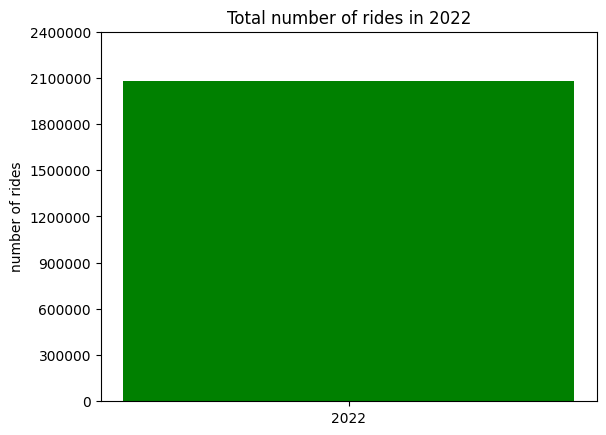

In [537]:
# Plot total number of rides for 2022
fig, ax = plt.subplots()

dates = "2022"
rides = sum(year_frequency["number of rides"])
bar_labels = dates

ax.bar(dates, rides, label=bar_labels, color='g', width=0.01)

ax.set_ylabel("number of rides")
ax.set_title("Total number of rides in 2022")
plt.yticks(np.arange(0, 2400000+1, 300000))

formatter = ax.yaxis.get_major_formatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)

plt.savefig('year_rides.png')
plt.show()

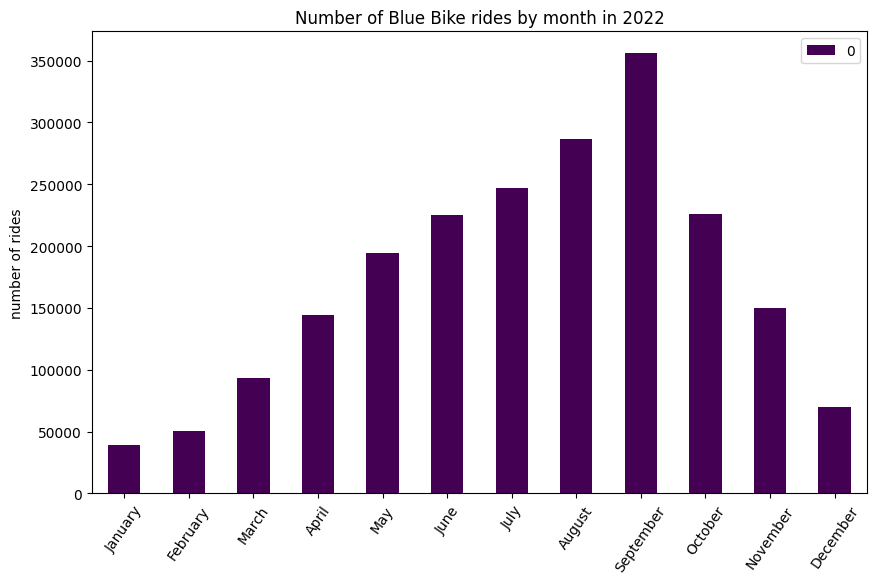

In [538]:
# Plot rides by month
fig, ax = plt.subplots()

dates = list(calendar.month_name)[1:]
monthly_plot_data = pd.DataFrame([sum(month_frequency[i]["number of rides"]) for i in range(len(month_frequency))])

monthly_plot_data.plot(ax=ax, kind='bar', figsize=(10,6), colormap='viridis')


ax.set_ylabel("number of rides")
ax.set_title("Number of Blue Bike rides by month in 2022")
ax.set_xticklabels(dates)
plt.xticks(rotation=55)

plt.savefig('month_rides.png')
plt.show()

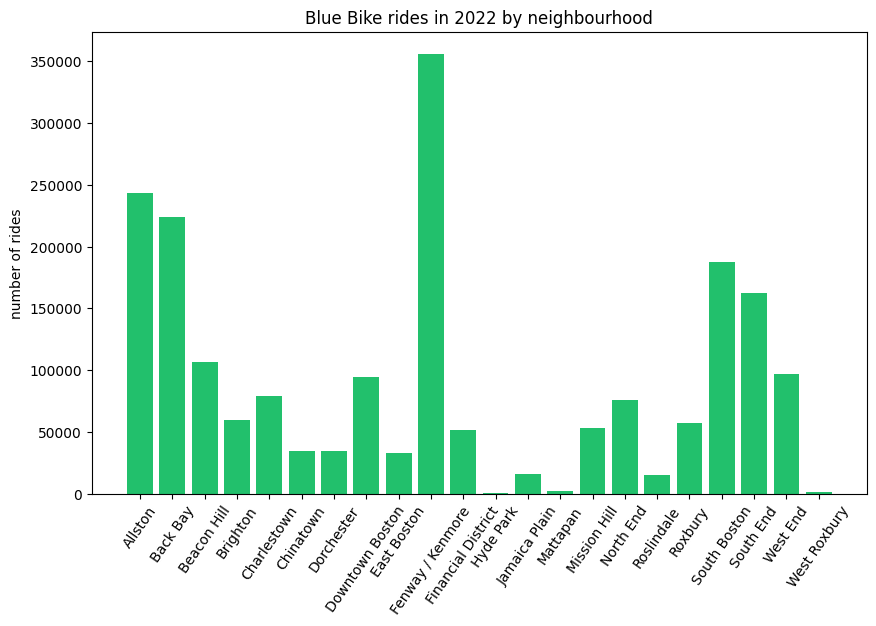

In [539]:
# Plot all rides by neighbourhood

fig, ax = plt.subplots(figsize=(10, 6))

neighbourhoods = year_frequency.groupby("neighbourhood").sum(["number of rides"]).index
rides = year_frequency.groupby("neighbourhood").sum(["number of rides"])["number of rides"]
bar_labels = neighbourhoods

ax.bar(neighbourhoods, rides, label=bar_labels, color='#22c06c')

ax.set_ylabel("number of rides")
ax.set_title("Blue Bike rides in 2022 by neighbourhood")
plt.xticks(rotation=55)

plt.savefig('year_neighbourhood_rides.png')
plt.show()

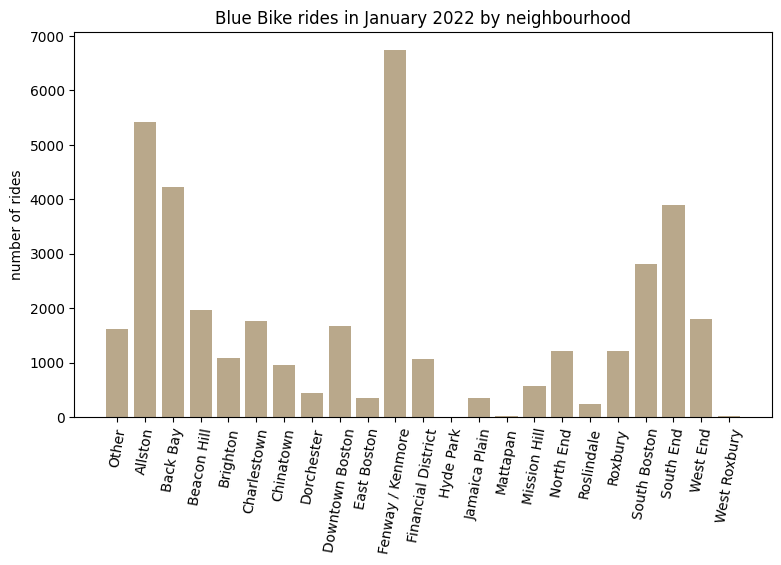

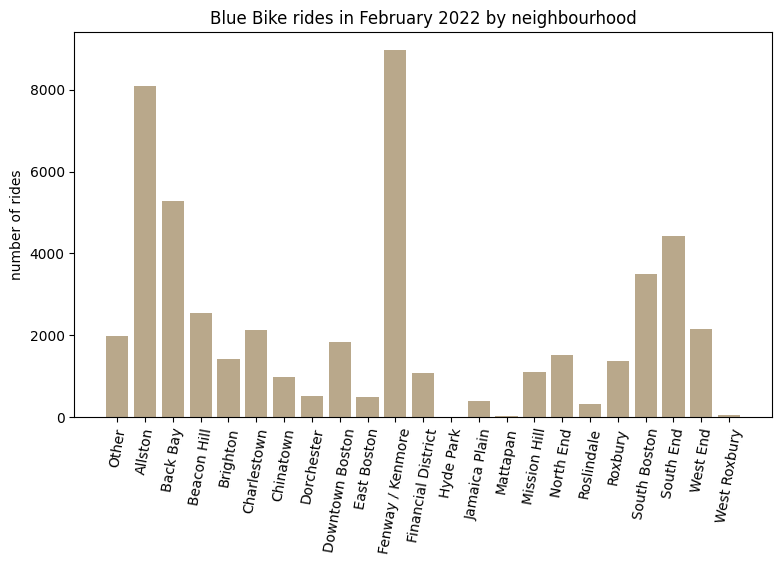

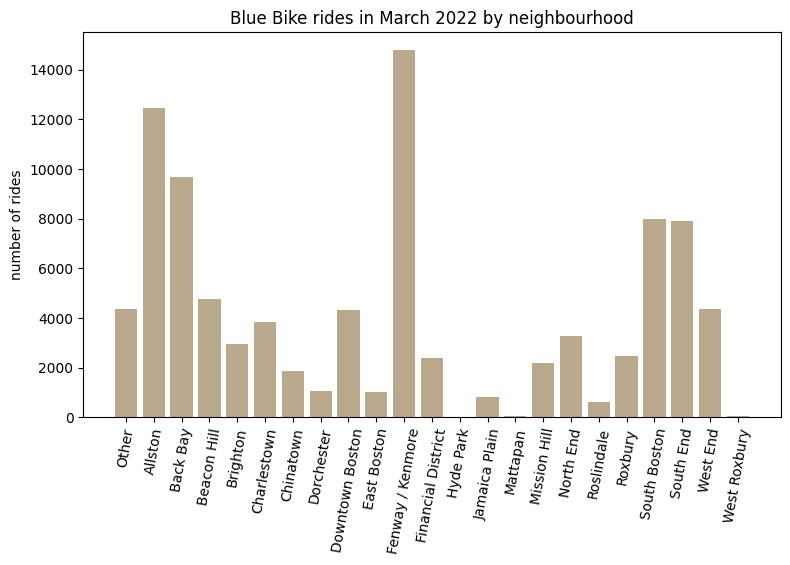

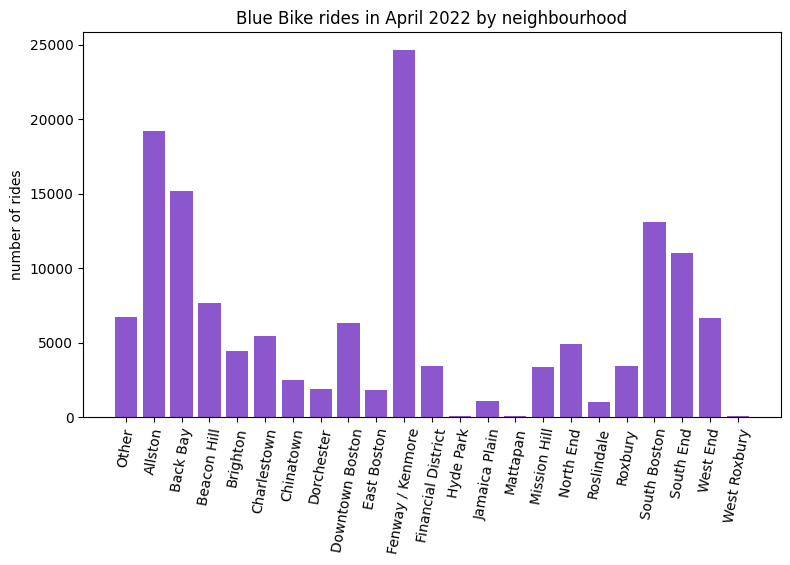

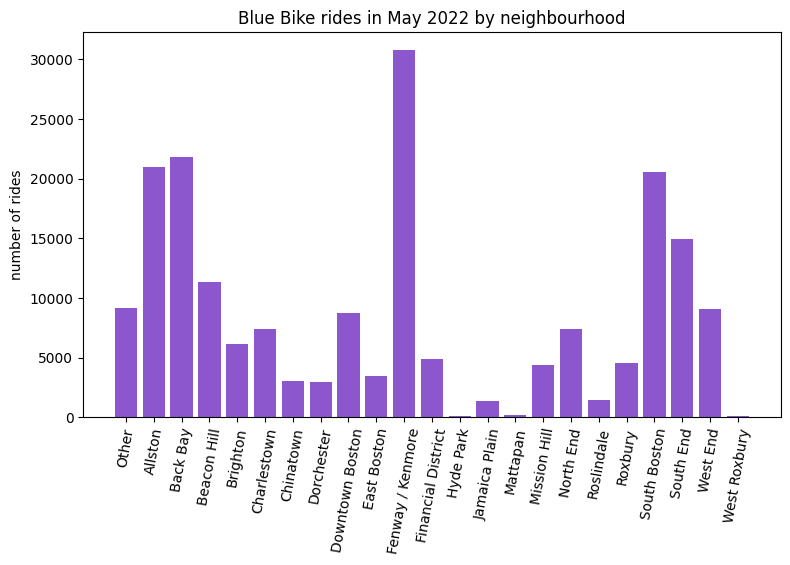

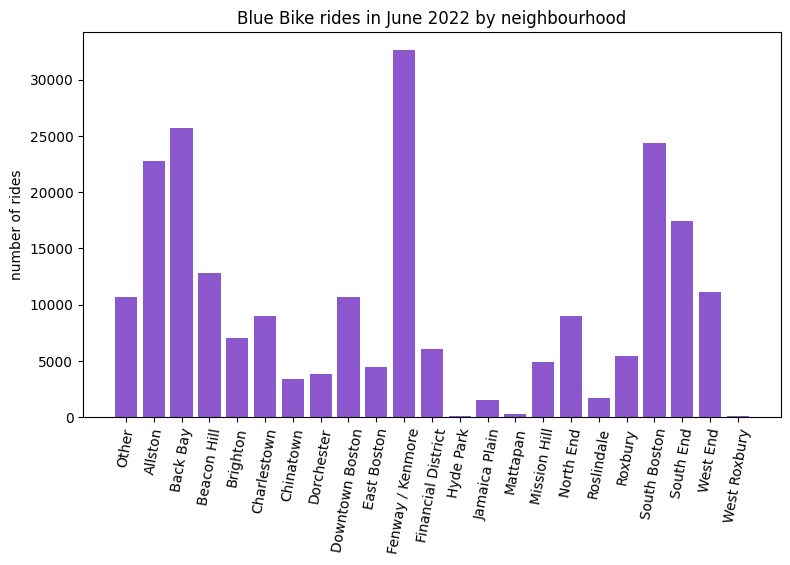

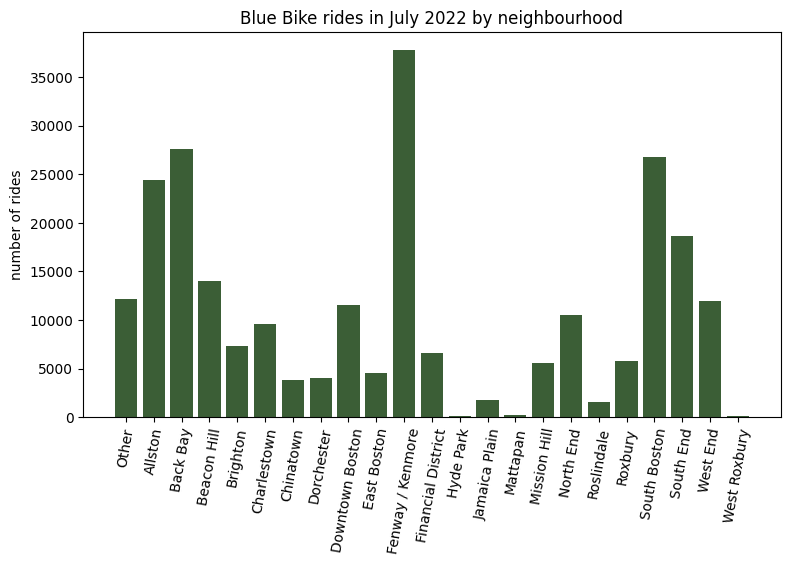

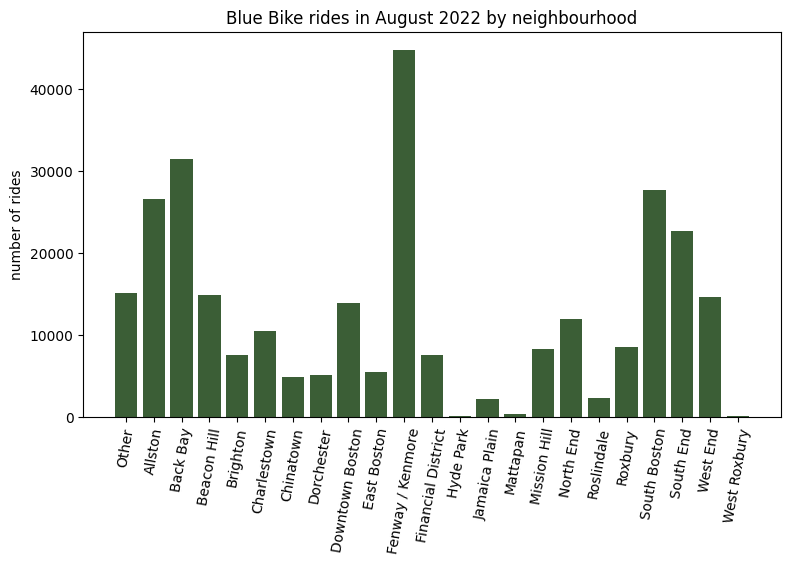

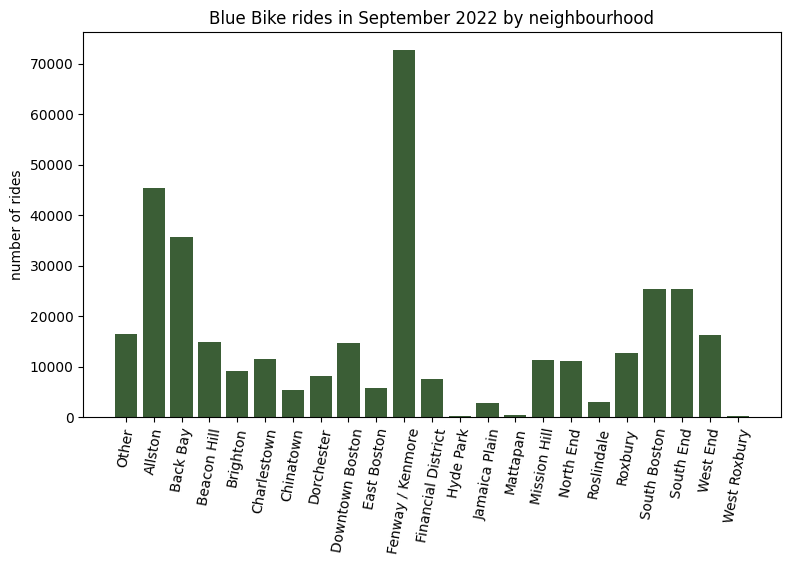

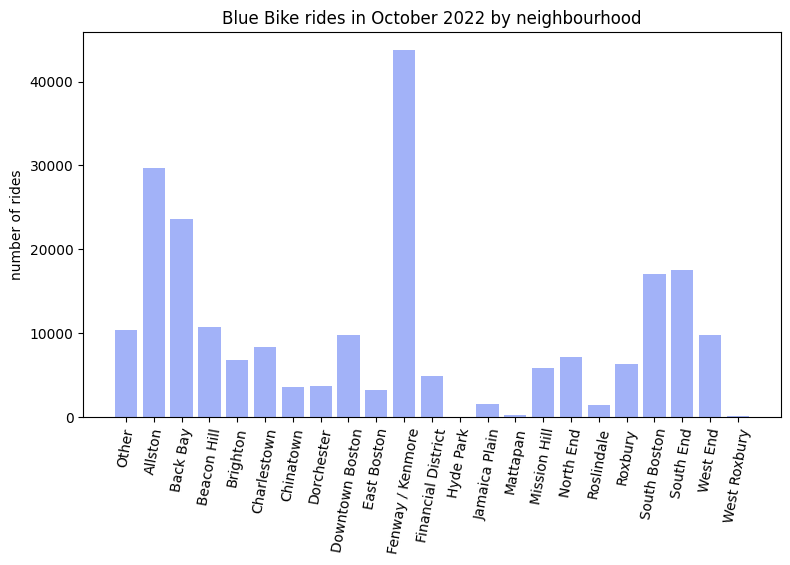

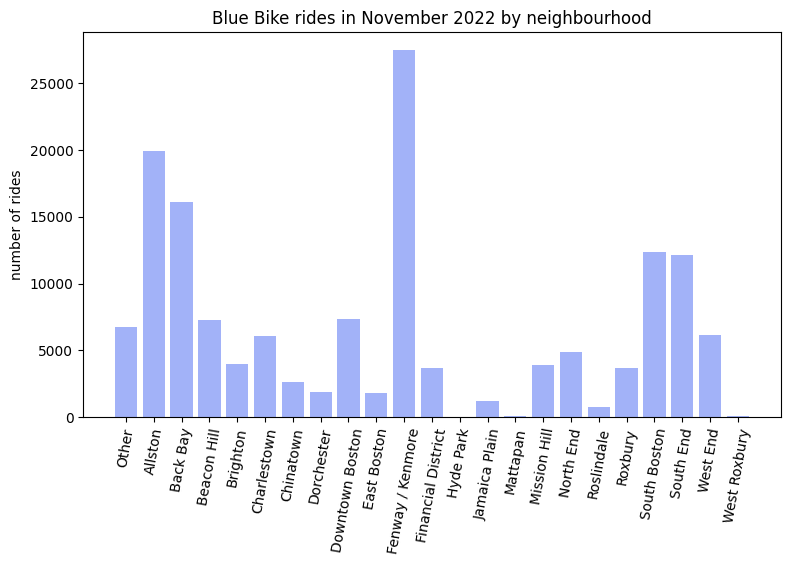

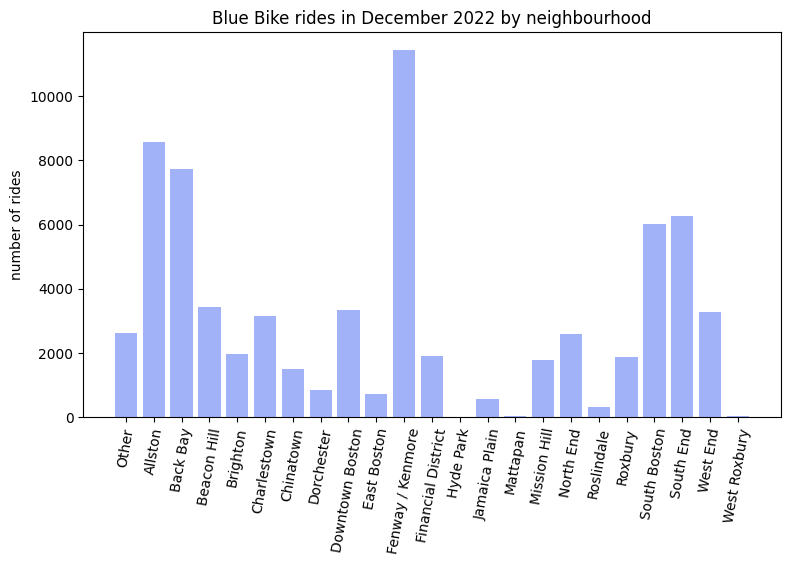

In [540]:
# Plot rides from each month by neighbourhood

colors = ["#b9a88b", "#8c56cc", "#3b5e36", "#a2b2f8"]

for i in range(len(month_frequency)):
    month = month_frequency[i]
    month_name = calendar.month_name[i + 1]

    fig, ax = plt.subplots(figsize=(9, 5))
    
    neighbourhoods = list(month.groupby("neighbourhood").sum(["number of rides"]).index)
    neighbourhoods[0] =  "Other"
    rides = month.groupby("neighbourhood").sum(["number of rides"])["number of rides"]
    bar_labels = neighbourhoods
    
    ax.bar(neighbourhoods, rides, label=bar_labels, color=colors[i // 3])
    
    ax.set_ylabel("number of rides")
    ax.set_title(f"Blue Bike rides in {month_name} 2022 by neighbourhood")
    plt.xticks(rotation=80)

    if i < 9:
        img_name = f'month_0{i + 1}_neighbourhood_rides.png'
    else:
        img_name = f'month_{i + 1}_neighbourhood_rides.png'
    
    plt.savefig(img_name)
    plt.show()

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


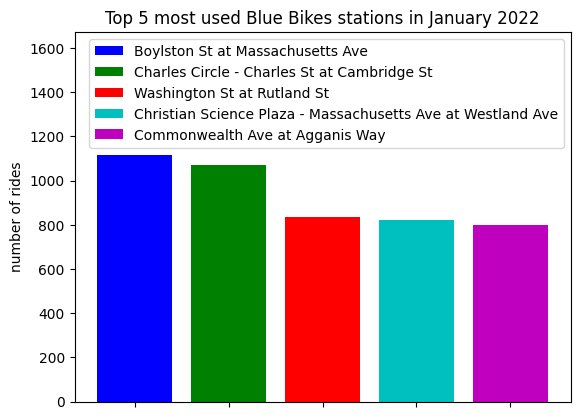

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


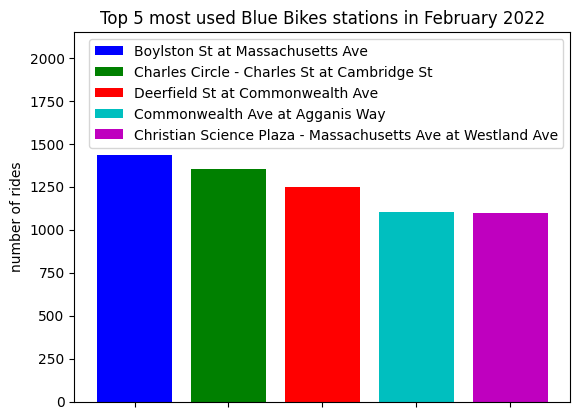

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


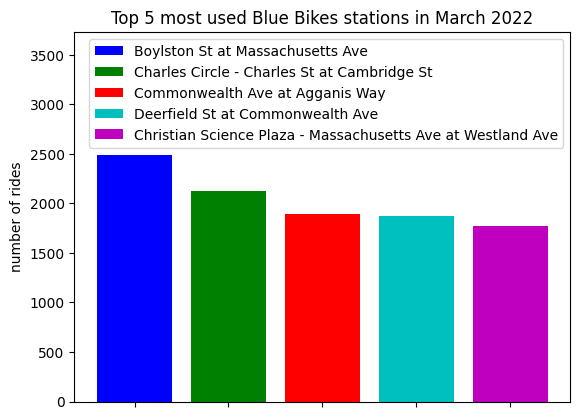

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


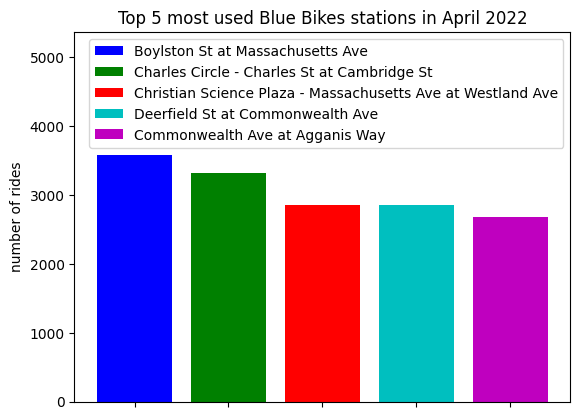

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


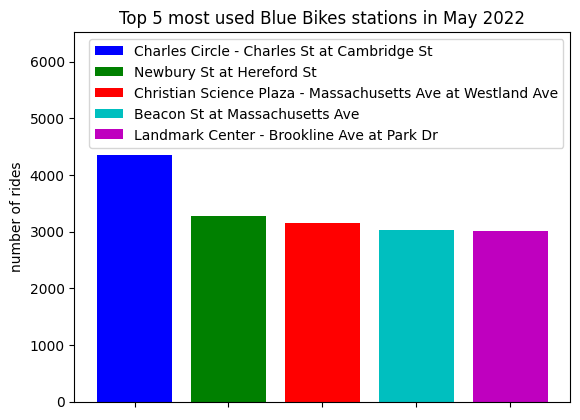

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


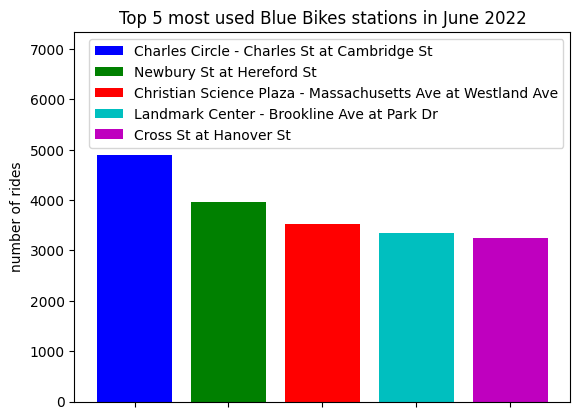

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


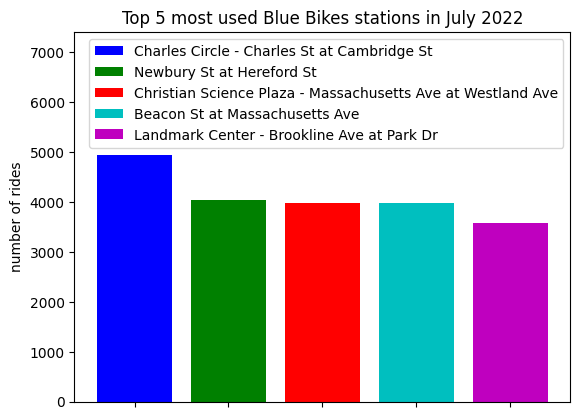

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


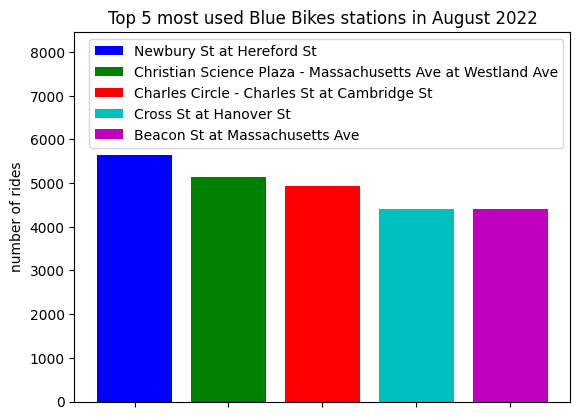

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


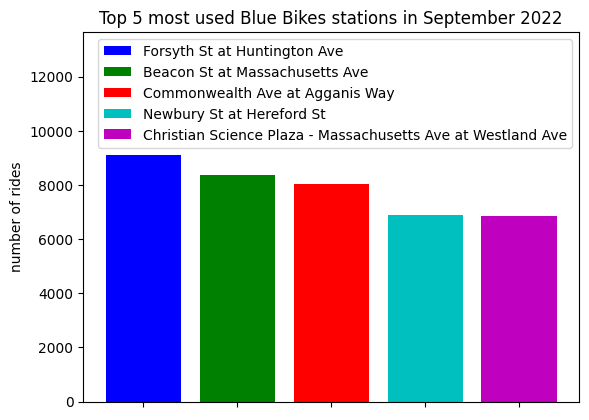

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


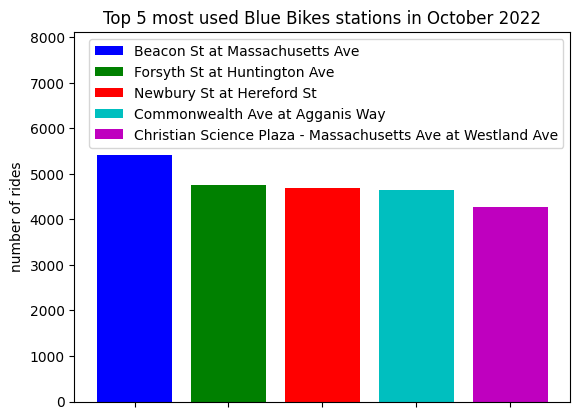

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


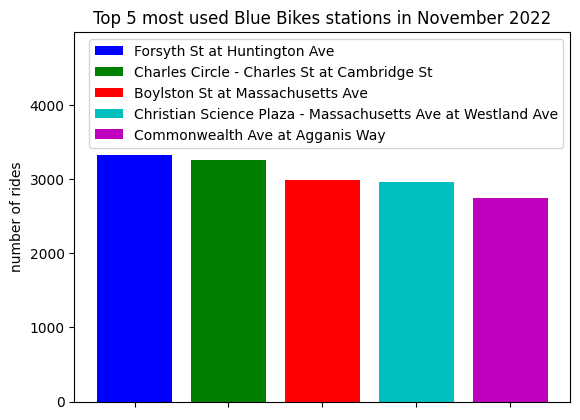

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3870983440.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


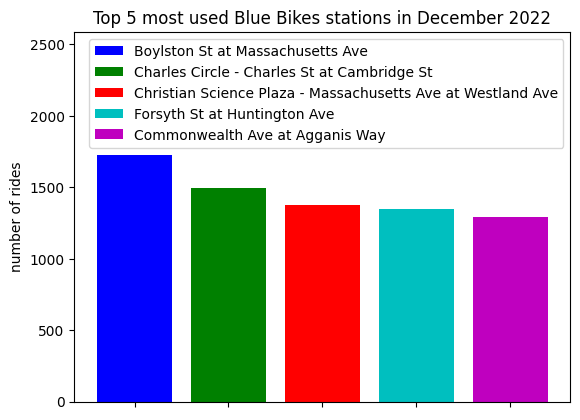

In [541]:
# Plot 5 most frequent start stations per month

bar_colors = [x for x in 'bgrcmyk']

for i in range(len(month_frequency)):
    month = month_frequency[i]
    month_name = calendar.month_name[i + 1]

    fig, ax = plt.subplots()
    
    stations = month.sort_values("number of rides", ascending=False)[:5]["start station name"]
    rides = month.sort_values("number of rides", ascending=False)[:5]["number of rides"]
    bar_labels = stations
    
    ax.bar(stations, rides, label=bar_labels, color=bar_colors)
    
    ax.set_ylabel("number of rides")
    ax.set_title(f"Top 5 most used Blue Bikes stations in {month_name} 2022")
    plt.ylim(0, max(rides) * 1.5)
    ax.set_xticklabels(['']*len(ax.get_xticks()))
    ax.tick_params(axis='x', labelsize=8)
    plt.legend()

    if i < 9:
        img_name = f'month_0{i + 1}_most_frequent_stations.png'
    else:
        img_name = f'month_{i + 1}_most_frequent_stations.png'
    
    plt.savefig(img_name)
    plt.show()

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


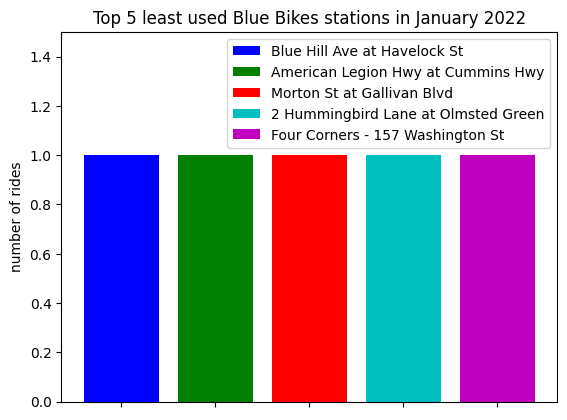

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


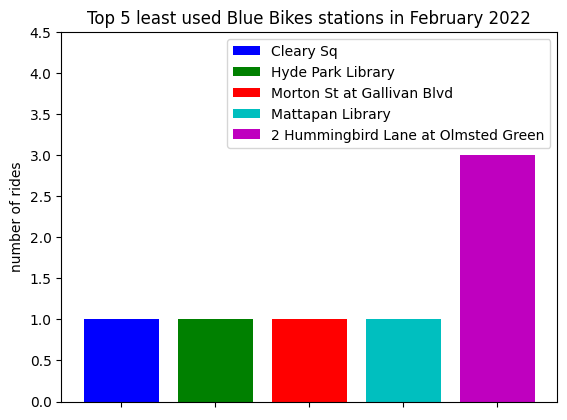

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


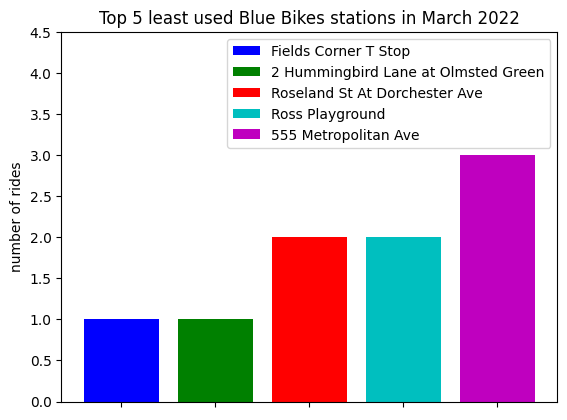

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


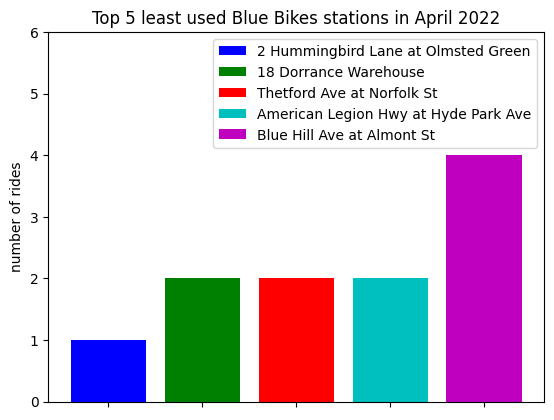

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


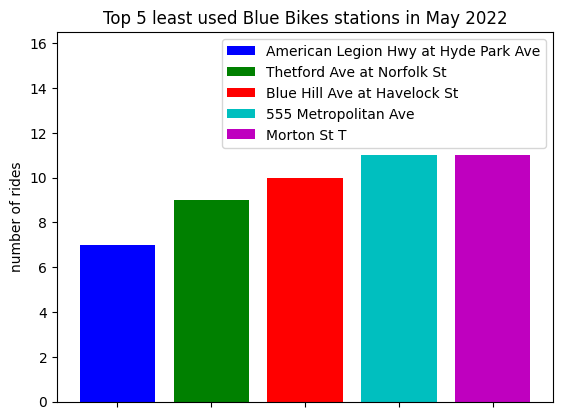

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


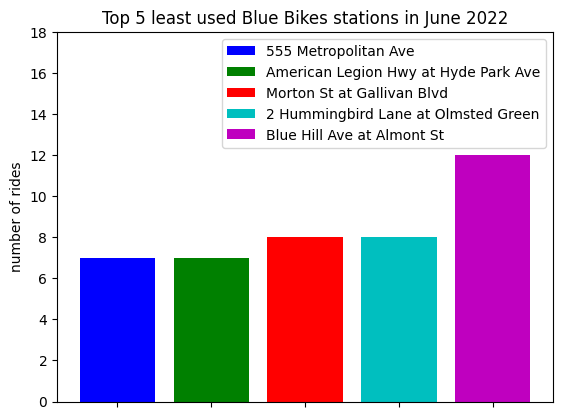

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


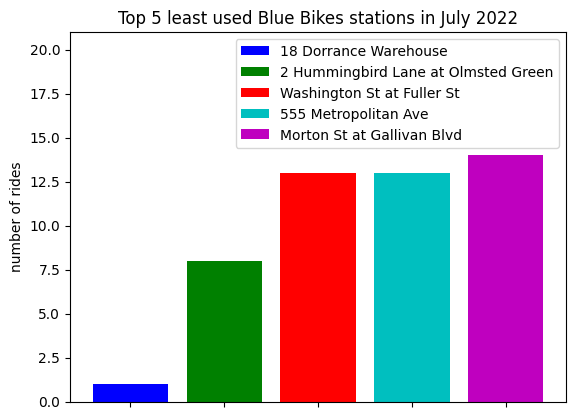

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


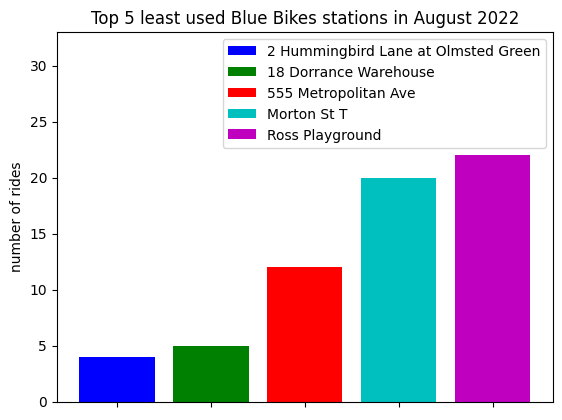

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


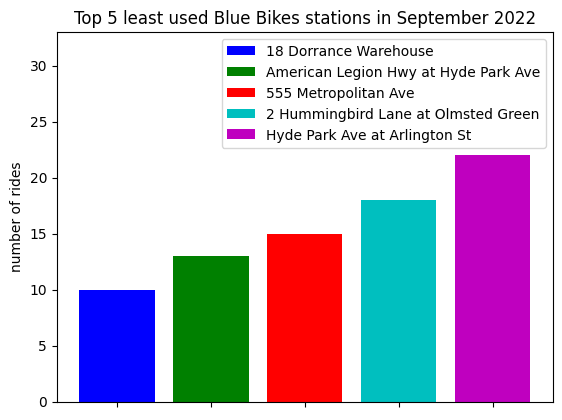

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


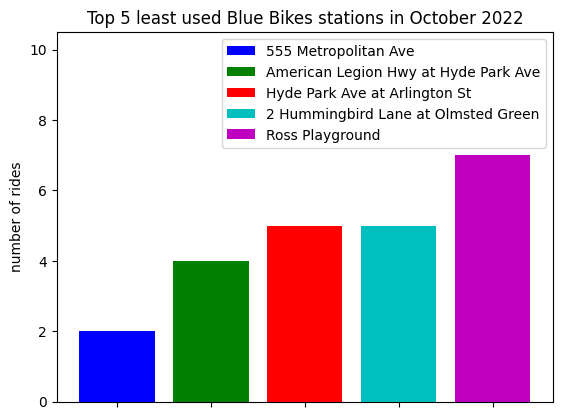

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


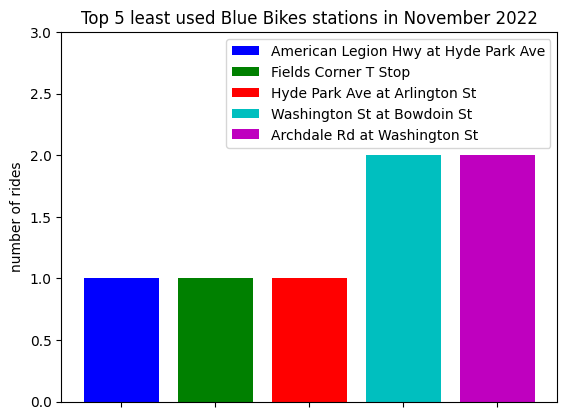

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3330072136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']*len(ax.get_xticks()))


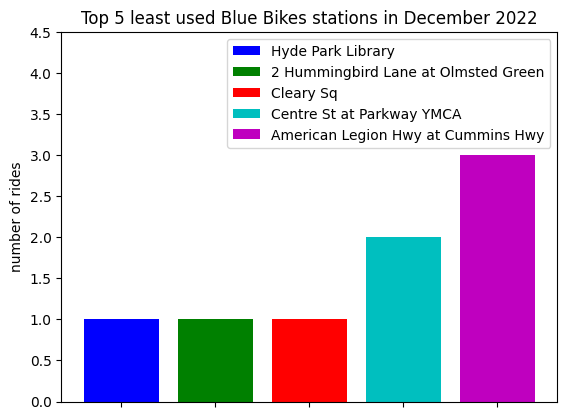

In [542]:
# Plot 5 least frequent start stations per month

bar_colors = [x for x in 'bgrcmyk']

for i in range(len(month_frequency)):
    month = month_frequency[i]
    month_name = calendar.month_name[i + 1]

    fig, ax = plt.subplots()
    
    stations = month.sort_values("number of rides", ascending=True)[:5]["start station name"]
    rides = month.sort_values("number of rides", ascending=True)[:5]["number of rides"]
    bar_labels = stations
    
    ax.bar(stations, rides, label=bar_labels, color=bar_colors)
    
    ax.set_ylabel("number of rides")
    ax.set_title(f"Top 5 least used Blue Bikes stations in {month_name} 2022")
    plt.ylim(0, max(rides) * 1.5)
    ax.set_xticklabels(['']*len(ax.get_xticks()))
    ax.tick_params(axis='x', labelsize=8)
    plt.legend()

    if i < 9:
        img_name = f'month_0{i + 1}_least_frequent_stations.png'
    else:
        img_name = f'month_{i + 1}_least_frequent_stations.png'
    
    plt.savefig(img_name)
    plt.show()

In [543]:
# Define function from homework assignment

def convert_map_to_png(map, filename):
    """
    Method to convert a folium map to a png file by
    saving the map as an html file and then taking a
    screenshot of the html file on the browser.

    map : folium map object
        The map to be converted to a png file
    filename : str, does not include file type
    """

    html_filename=f'{filename}.html'
    map.save(html_filename)

    tmpurl=f'file://{os.getcwd()}/{html_filename}'
    
    try:
        try:
            browser = webdriver.Firefox()
        except:
            browser = webdriver.Chrome()
    except:
        browser = webdriver.Safari()

    browser.get(tmpurl)
    time.sleep(5)
    browser.save_screenshot(f'{filename}.png')
    browser.quit()
    os.remove(html_filename)

    return Image(f'{filename}.png')

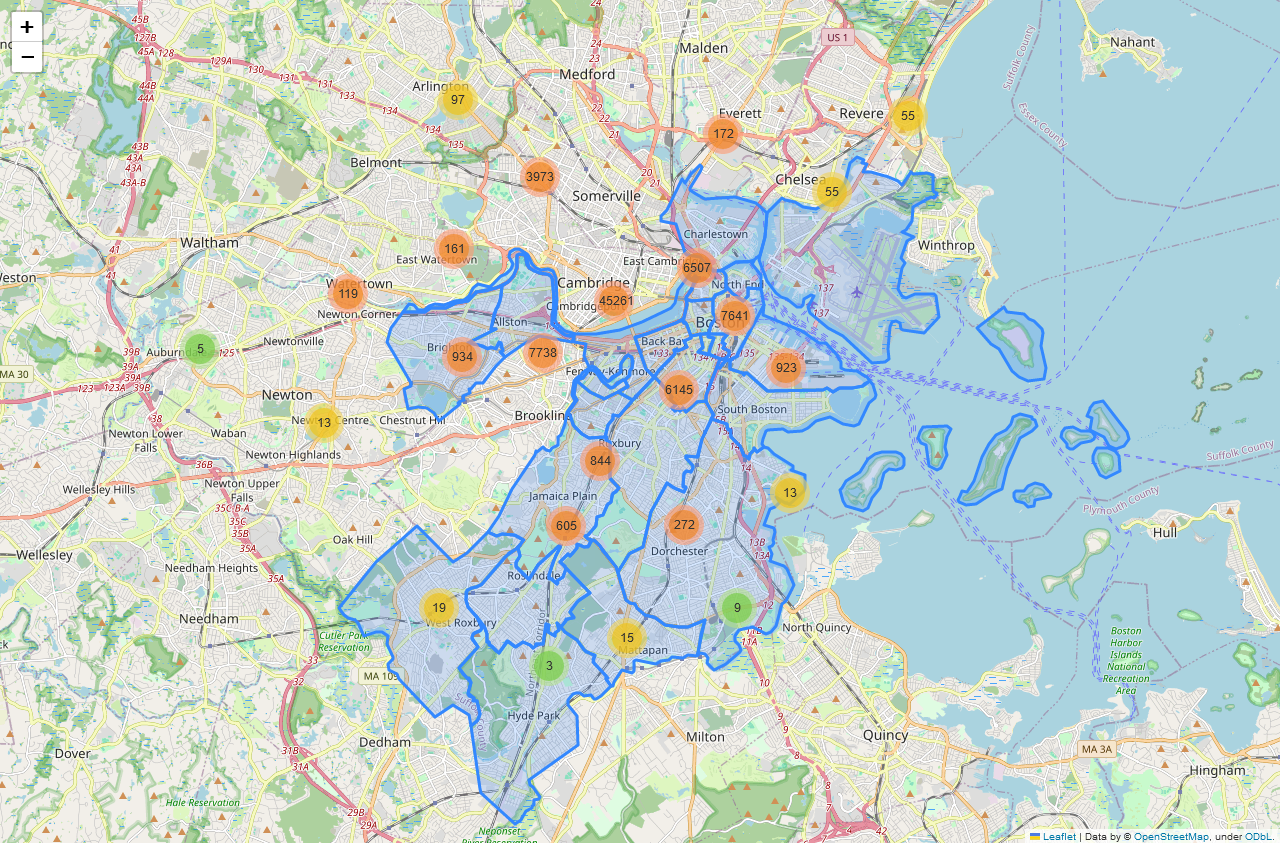

In [546]:
# map for month of January of rides across the city
# map for month of September of rides across the city

boston_map = folium.Map(location=[42.330377, -71.088132], zoom_start = 12.25)

layer_1 = folium.GeoJson(
    data=(open("data/Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Tracts.geojson", "r").read()),
    name="Neighborhoods")

layer_1.add_to(boston_map)

marker_cluster = FastMarkerCluster(data=months[0].loc[:, ['start station latitude', 'start station longitude']], ).add_to(boston_map)

convert_map_to_png(boston_map, '01_rides_map')
Image('01_rides_map.png')

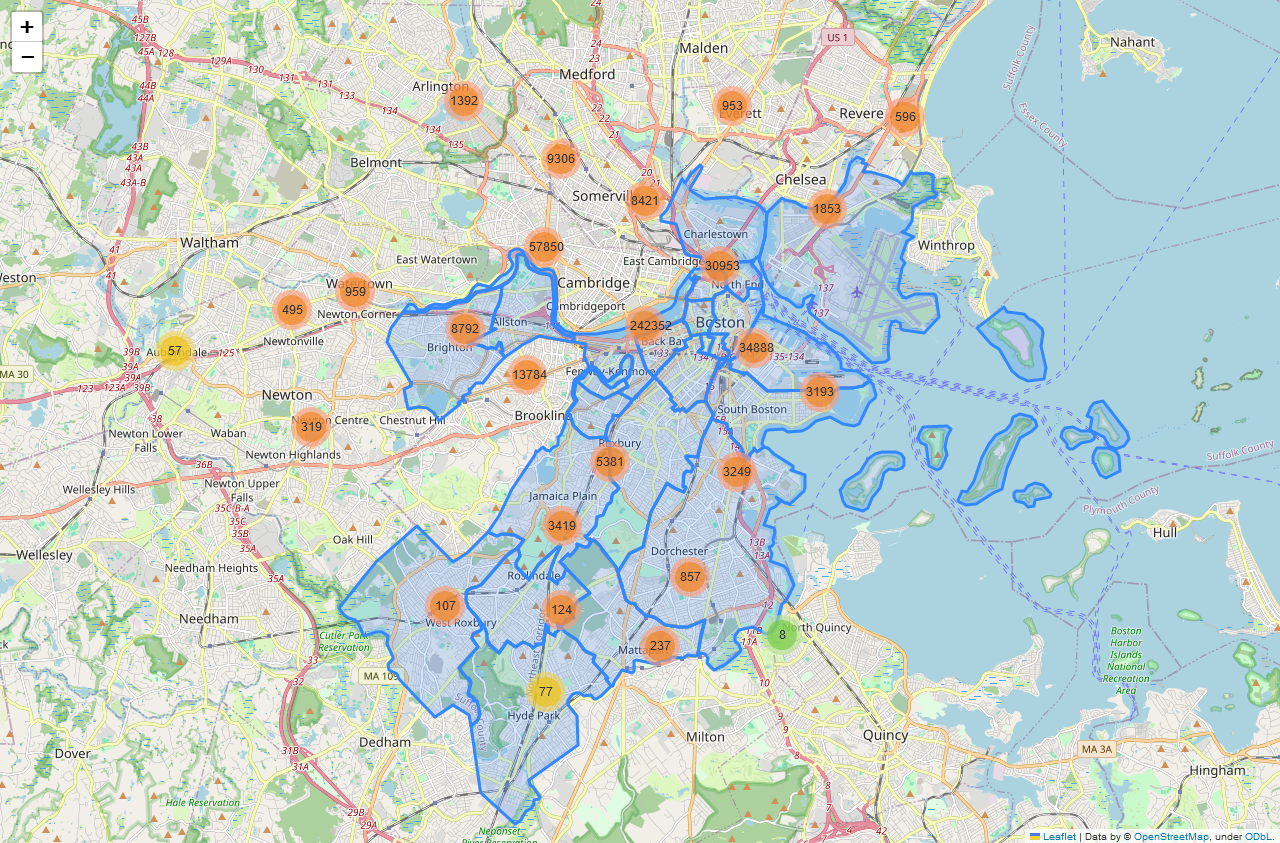

In [547]:
boston_map = folium.Map(location=[42.330377, -71.088132], zoom_start = 12.25)

layer_1 = folium.GeoJson(
    data=(open("data/Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Tracts.geojson", "r").read()),
    name="Neighborhoods")

layer_1.add_to(boston_map)

marker_cluster = FastMarkerCluster(data=months[6].loc[:, ['start station latitude', 'start station longitude']], ).add_to(boston_map)

convert_map_to_png(boston_map, '07_rides_map')
Image('07_rides_map.png')

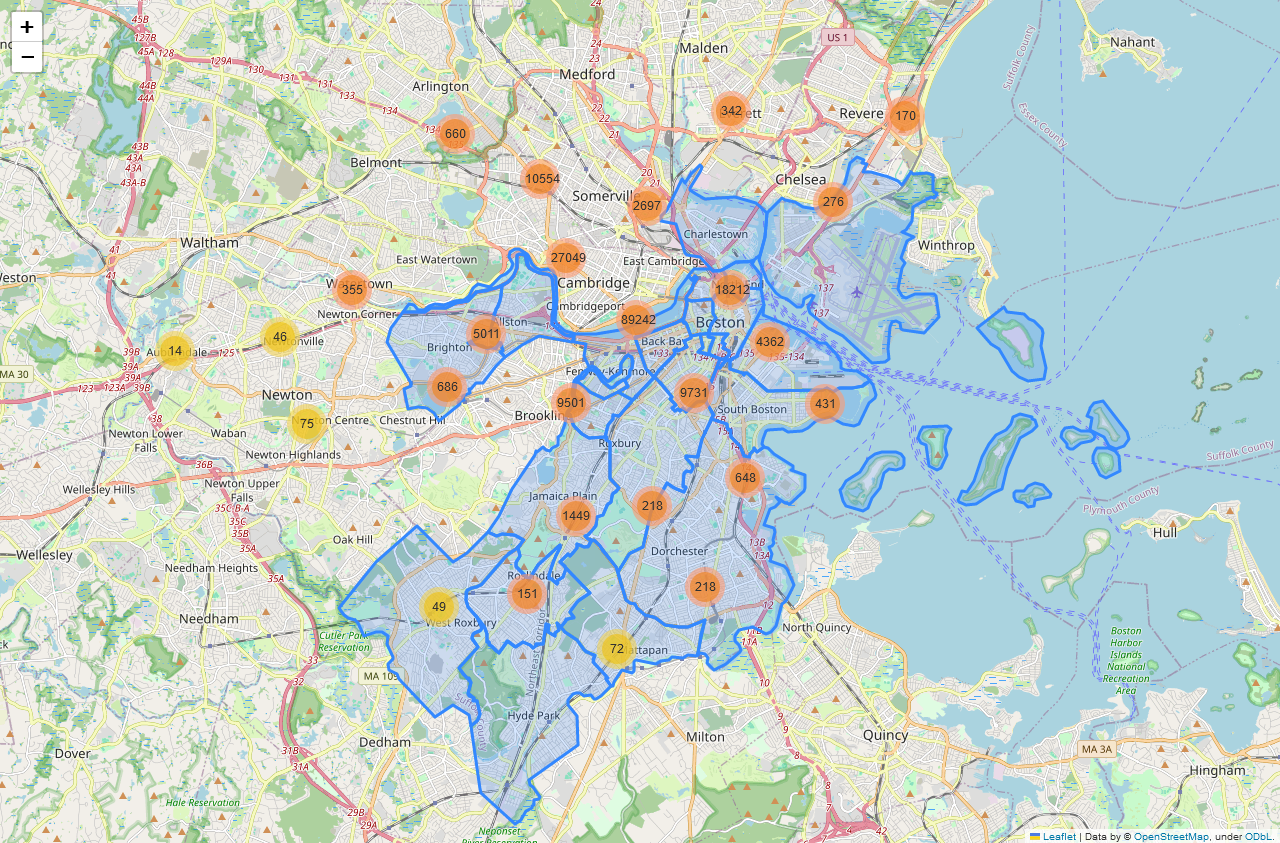

In [548]:
boston_map = folium.Map(location=[42.330377, -71.088132], zoom_start = 12.25)

layer_1 = folium.GeoJson(
    data=(open("data/Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Tracts.geojson", "r").read()),
    name="Neighborhoods")

layer_1.add_to(boston_map)

marker_cluster = FastMarkerCluster(data=months[2].loc[:, ['start station latitude', 'start station longitude']], ).add_to(boston_map)

convert_map_to_png(boston_map, '03_rides_map')
Image('03_rides_map.png')

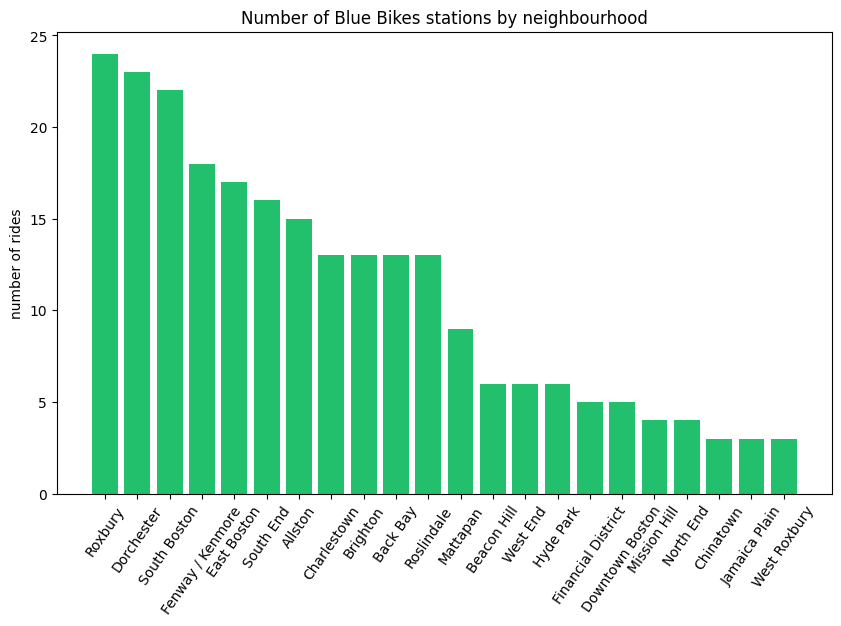

In [549]:
# Plot number of stations by neighbourhood

fig, ax = plt.subplots(figsize=(10, 6))

neighbourhoods = pd.DataFrame(year_frequency["neighbourhood"].value_counts()).index
rides = pd.DataFrame(year_frequency["neighbourhood"].value_counts())["count"]
bar_labels = neighbourhoods

ax.bar(neighbourhoods, rides, label=bar_labels, color='#22c06c')

ax.set_ylabel("number of rides")
ax.set_title("Number of Blue Bikes stations by neighbourhood")
plt.xticks(rotation=55)

plt.savefig('stations_by_neighbourhood.png')
plt.show()

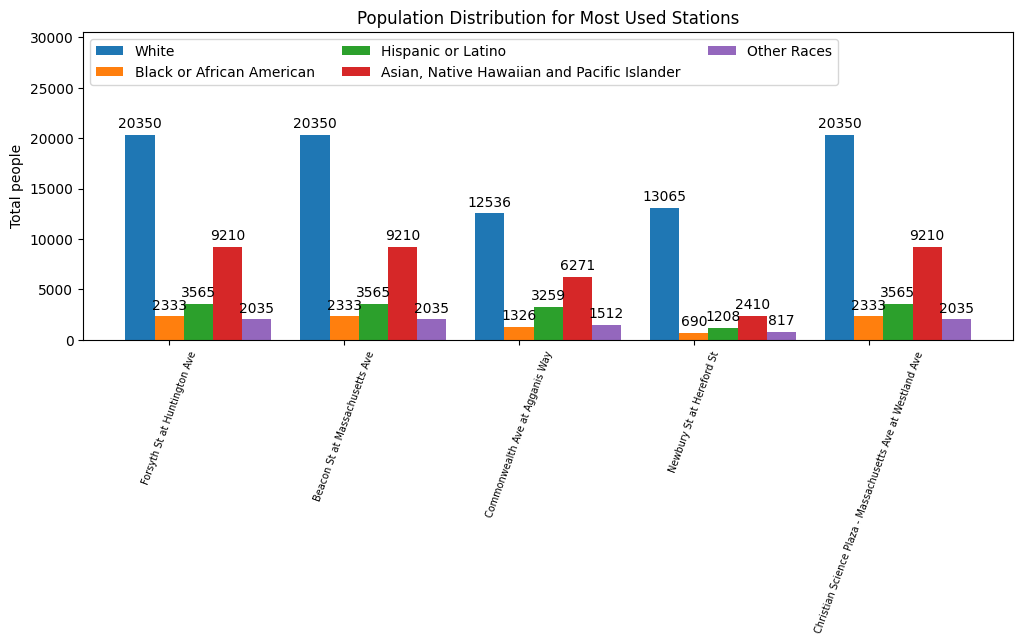

In [482]:
month = month_frequency[8]
month_name = calendar.month_name[9]

max_val = 0

fig, ax = plt.subplots(figsize=(12,4))

stations = month.sort_values("number of rides", ascending=False)[:5]["start station name"]
neighborhoods = month.sort_values("number of rides", ascending=False)[:5]["neighbourhood"]
categories = ["White", "Black or African American",  "Hispanic or Latino",
              "Asian, Native Hawaiian and Pacific Islander", "Other Races"]
populations = []
for n in neighborhoods:
    if n == "Fenway / Kenmore":
        n = "Fenway"
    populations.append(census_data[census_data["Neighbourhood"] == n][categories])
bar_labels = stations

populations = pd.concat(populations)
populations.index = stations

x = np.arange(len(populations)) 
width = 0.166667
multiplier = 0

for i in range(len(populations)):
    people = populations.iloc[:, i]
    people = [int(p) for p in list(people)]
    if max(people) > max_val:
        max_val = max(people)
    attribute = categories[i]
    offset = width * multiplier
    rects = ax.bar(x + offset, people, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Total people")
ax.set_title('Population Distribution for Most Used Stations')
ax.set_xticks(x + width, populations.index)
ax.legend(loc='upper left', ncols=3)
plt.ylim(0, max_val * 1.5)
plt.xticks(rotation=70)
ax.tick_params(axis='x', labelsize=7)

plt.savefig('most_used_demographics.png')
plt.show()

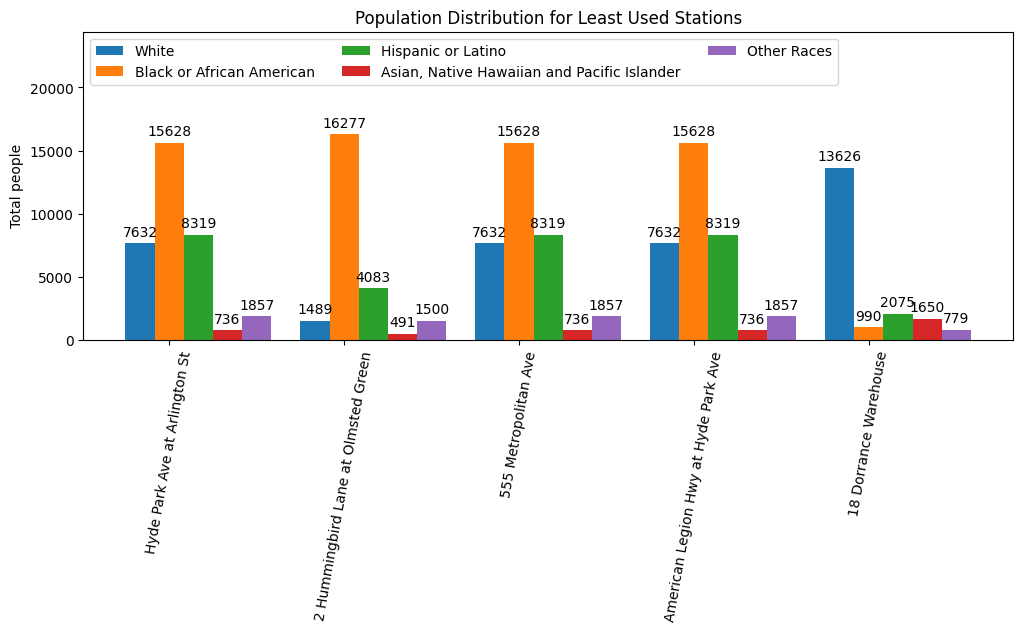

In [477]:
month = month_frequency[8]
month_name = calendar.month_name[9]
max_val = 0

fig, ax = plt.subplots(figsize=(12,4))

stations = month.sort_values("number of rides", ascending=False)[-5:]["start station name"]
neighborhoods = month.sort_values("number of rides", ascending=False)[-5:]["neighbourhood"]
categories = ["White", "Black or African American",  "Hispanic or Latino",
              "Asian, Native Hawaiian and Pacific Islander", "Other Races"]
populations = []
for n in neighborhoods:
    if n == "Fenway / Kenmore":
        n = "Fenway"
    populations.append(census_data[census_data["Neighbourhood"] == n][categories])
bar_labels = stations

populations = pd.concat(populations)
populations.index = stations

x = np.arange(len(populations)) 
width = 0.166667
multiplier = 0

for i in range(len(populations)):
    people = populations.iloc[:, i]
    people = [int(p) for p in list(people)]
    if max(people) > max_val:
        max_val = max(people)
    attribute = categories[i]
    offset = width * multiplier
    rects = ax.bar(x + offset, people, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Total people")
ax.set_title('Population Distribution for Least Used Stations')
ax.set_xticks(x + width, populations.index)
ax.legend(loc='upper left', ncols=3)
plt.xticks(rotation=80)
plt.ylim(0, max_val * 1.5)

plt.savefig('least_used_demographics.png')
plt.show()

C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3974648078.py:20: DeprecationWarning: DataFrame._data is deprecated and will be removed in a future version. Use public APIs instead.
  data = pd.DataFrame(stations, populations)
C:\Users\pjbro\AppData\Local\Temp\ipykernel_24352\3974648078.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


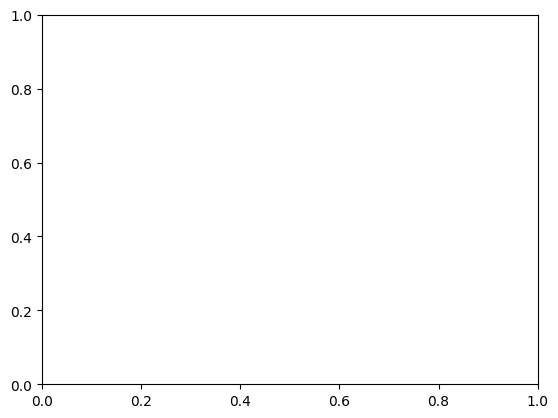

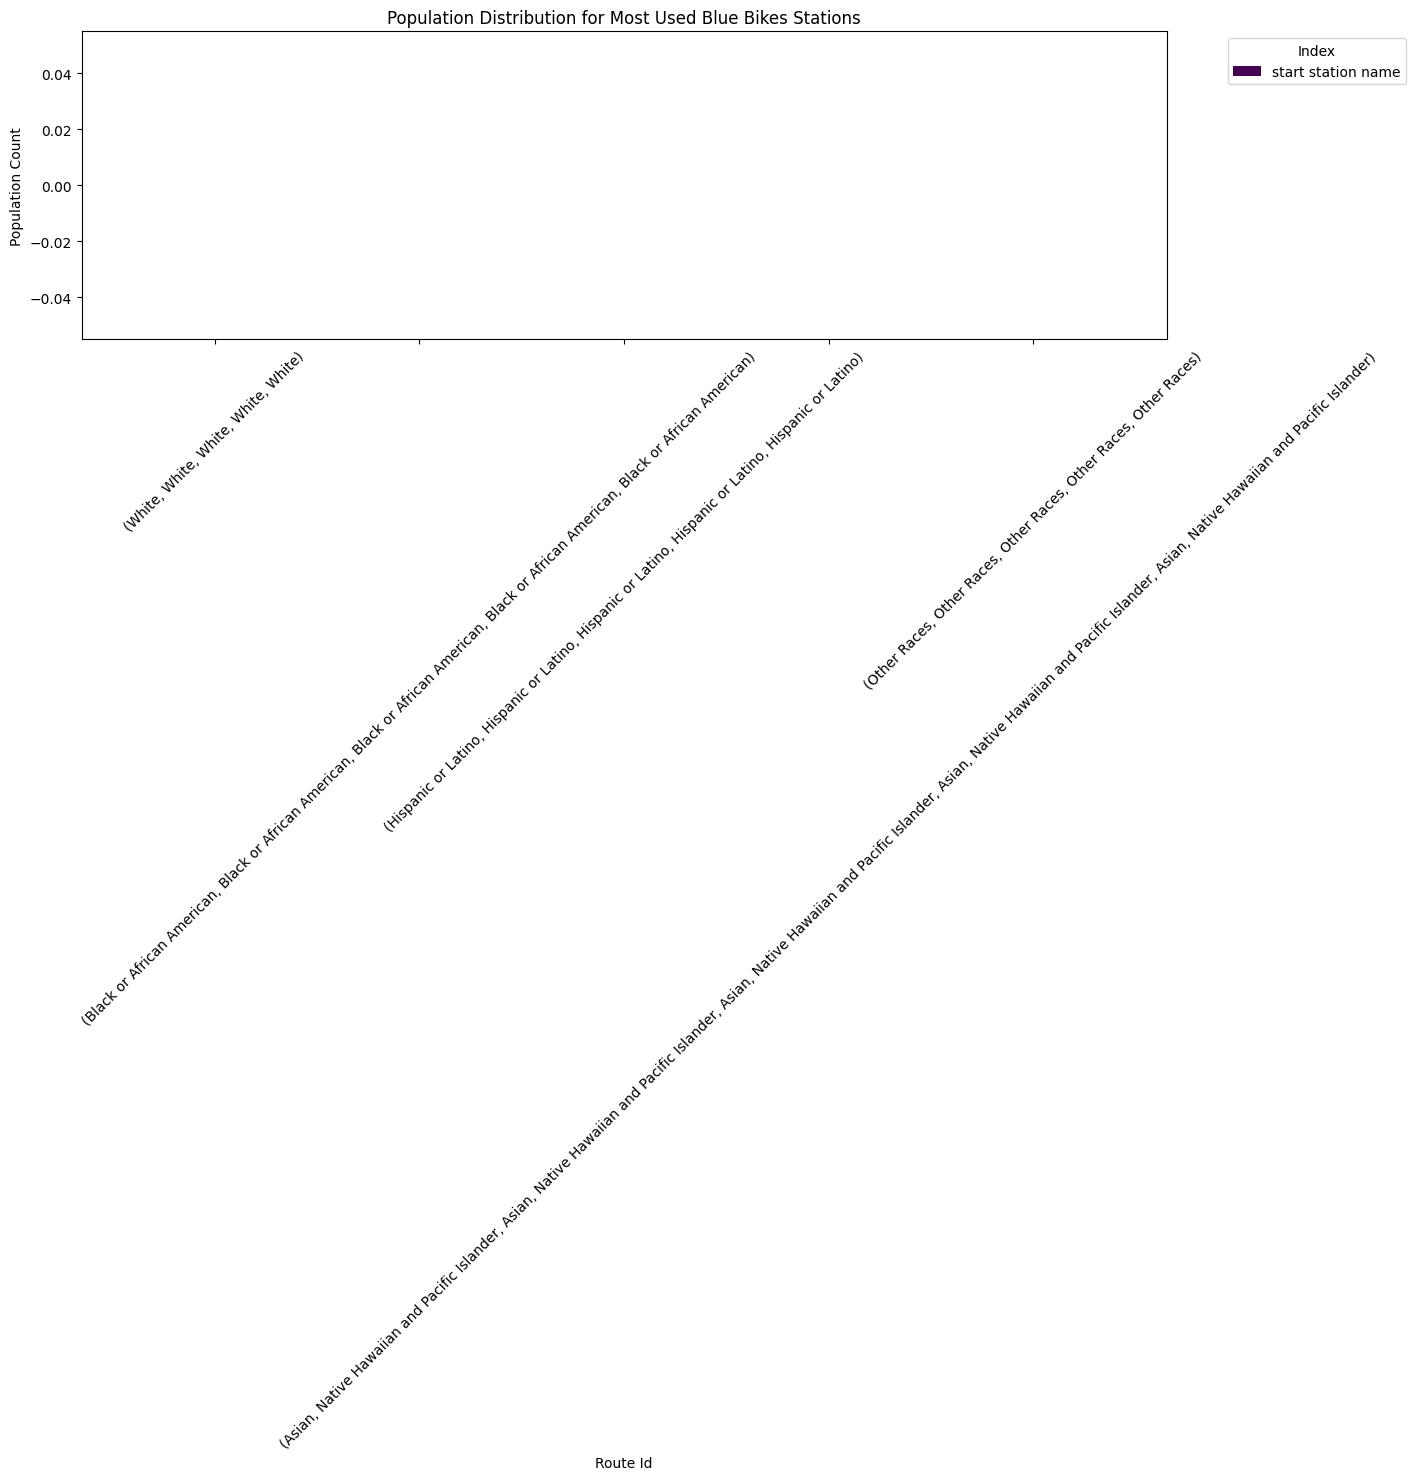

In [347]:
# demographics of 5 most accessible Blue Bikes stations in September 2022
#
#
#
# TODO: finish the graph I was trying to create here at some point

month = month_frequency[8]
month_name = calendar.month_name[9]

fig, ax = plt.subplots()

stations = month.sort_values("number of rides", ascending=False)[:5]["start station name"]
neighborhoods = month.sort_values("number of rides", ascending=False)[:5]["neighbourhood"]
populations = []
for n in neighborhoods:
    if n == "Fenway / Kenmore":
        n = "Fenway"
    populations.append(census_data[census_data["Neighbourhood"] == n][["White", "Black or African American",  "Hispanic or Latino",
                                                                     "Asian, Native Hawaiian and Pacific Islander", "Other Races"]])
bar_labels = stations

data = pd.DataFrame(stations, populations)

data.plot(kind='bar', figsize=(14,4), colormap='viridis',width=0.8)
plt.xlabel('Route Id')
plt.ylabel('Population Count')
plt.title('Population Distribution for Most Used Blue Bikes Stations')
plt.legend(title='Index', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

img_name = f'september_most_frequent_neighbourhood_distribution.png'

plt.savefig(img_name)
plt.show()